In [1]:
# Look at the Vo data - households and contact network; add some visualisation of testing over time

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as st
from scipy import sparse
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [3]:
df = pd.read_csv('./vo_data.csv')
df

,id,household_id,age_group,fever,fever_temperature,cough,sore_throat,malaise,headache,diarrhea,...,first_sampling,second_sampling,positive,hospitalized,deceased,first_symptoms_date,clinical_condition_at_hospitalization,first_hospitalization_date,discharge_date,death_date
0,NTdvKuxi,0ccb6352,51-60,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,Negative,Negative,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gDKJjToZ,b6e428b2,41-50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Negative,Negative,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,lzTowLhG,6e10a063,00-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Negative,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NUATtRZf,6e10a063,41-50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Negative,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZJripFlV,66a74806,51-60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Negative,Negative,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,dgINwYWu,e7106745,51-60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Negative,Negative,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2896,pRchVltM,43ce0f8f,71-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Negative,Negative,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2897,AhIzCBNu,3f9a9dfc,41-50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Negative,Negative,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2898,pFqmFbyF,e7106745,11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Negative,Negative,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for x in df.columns[104:123]:
    print(x)

In [4]:
# indices taken from the vo_legend file
symptom_indices = range(3,13)
contact_indices = range(13,104)
testday_indices = range(104,123)

In [7]:
hcol = df.household_id.values
hhids = pd.unique(df.household_id)
len(hhids)

1299

In [14]:
hh_tests = []
ages = []
symptoms = []
for hid in hhids:
    dfh = df[df.household_id == hid]
    tests = dfh.iloc[:,testday_indices].values
    aa = dfh.iloc[:,2].values
    ss = dfh.symptomatic.values
    tests[tests=='Neg'] = 0
    tests[tests=='Pos'] = 1
    hh_tests.append(tests)
    ages.append(aa)
    symptoms.append(ss)

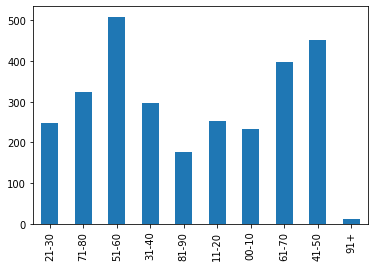

In [9]:
(df.age_group).value_counts(sort=False).plot(kind='bar')

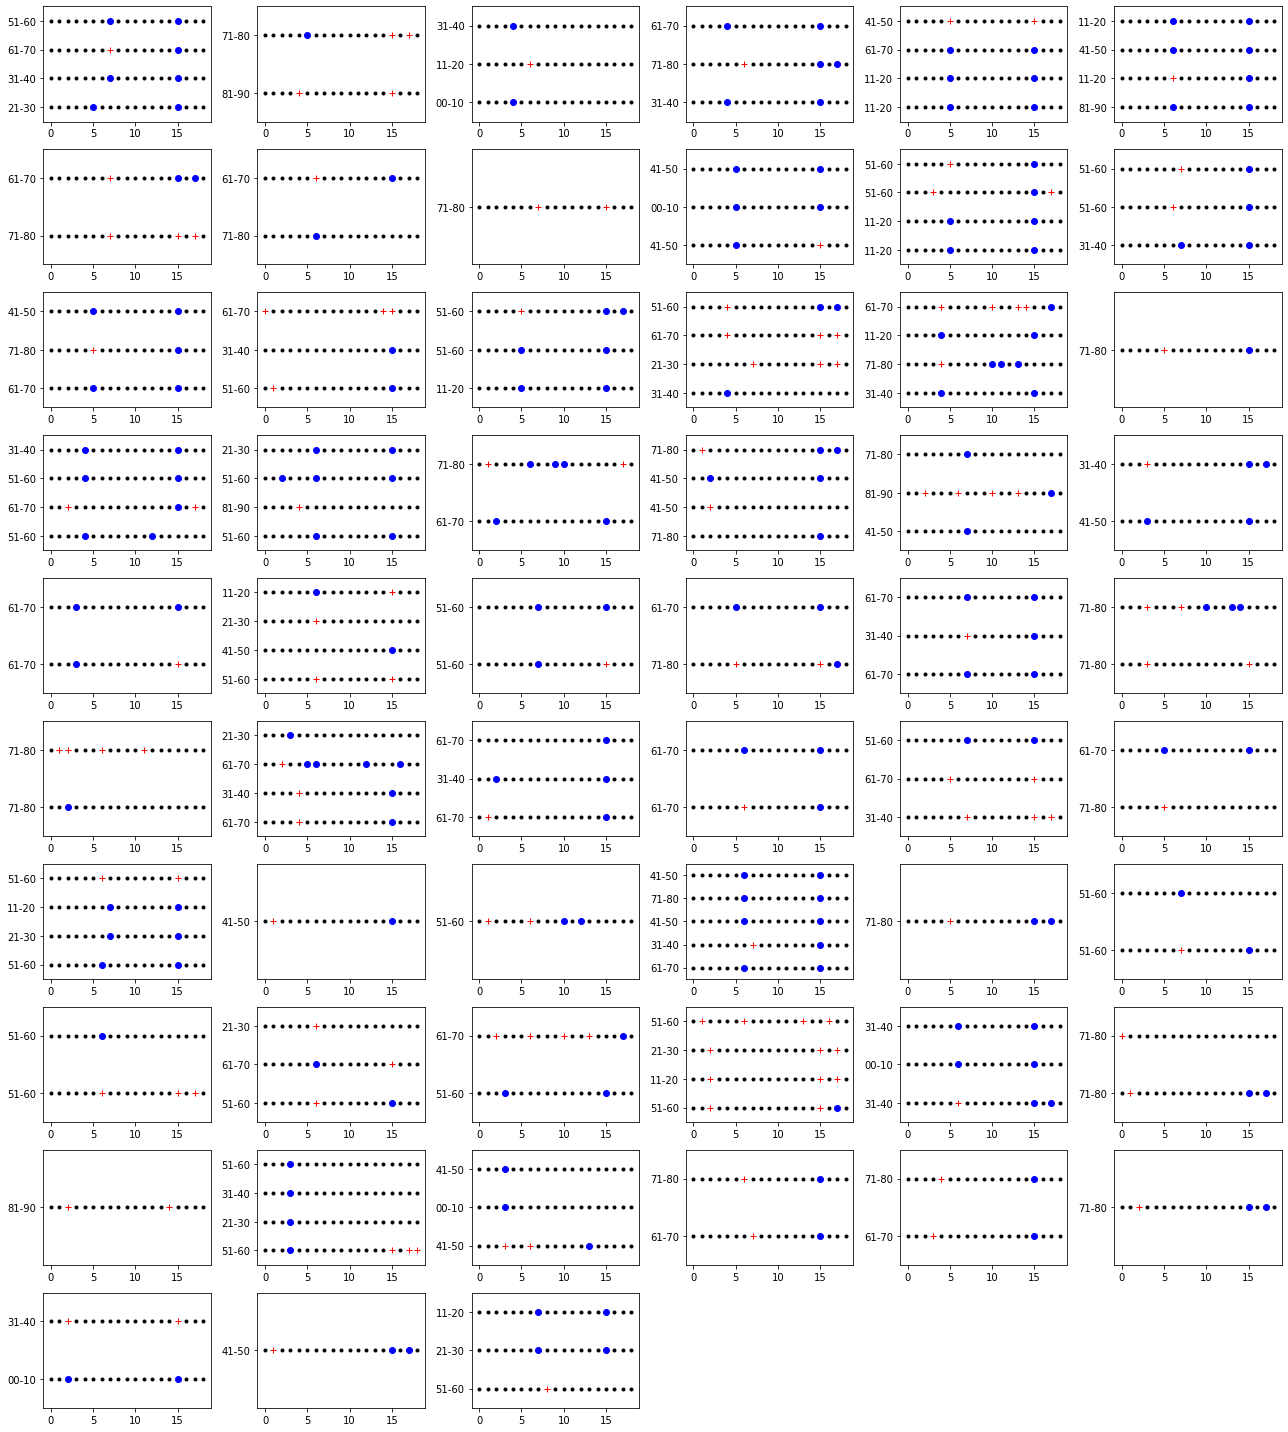

In [10]:
k=0
plt.figure(figsize=(18,20))
for j in range(0,len(hh_tests)):
    tests = hh_tests[j]
    nn, tt = tests.shape
    if ((tests[tests==1]).size > 0):
        #print(tests)
        k+=1
        plt.subplot(10,6,k)
        for y in range(0,nn):
            for t in range(0,tt):
                if (tests[y,t] == 1):
                    plt.plot(t,y,marker='+',c='r')
                elif (tests[y,t] == 0):
                    plt.plot(t,y,marker='o',c='b')
                else:
                    plt.plot(t,y,marker='.',c='k')
        plt.ylim([-0.5, nn-0.5]) 
        plt.yticks(np.arange(0,nn),ages[j])
plt.tight_layout()

In [ ]:
print(hh_tests)

In [16]:
from pickle import dump

with open('vo-testing-data.pkl','wb') as f:
    dump((hh_tests,ages,symptoms),f)

In [ ]:
itxt = df.id.values
jtxt = df.columns.values[contact_indices]
ii = range(1,len(itxt)+1)
t2i = dict(zip(itxt,ii)) # this will be a dictionary storing lookup from code to node

In [ ]:
k = len(t2i) # This will count the number of nodes
IJ = [] # This is for import into networkx
for jt in jtxt:
    if jt in t2i.keys():
        j = t2i[jt]
    else:
        k += 1
        t2i[jt] = k
        j = k
    traced = df[jt].values
    for i in np.where(~np.isnan(traced))[0]:
        IJ.append((j, i))
I = range(1,k+1)

In [ ]:
DG = nx.DiGraph()
DG.add_nodes_from(I)
DG.add_edges_from(IJ)

In [ ]:
c = []
posi = ((df['first_sampling'].values == 'Positive') | (df['second_sampling'].values == 'Positive'))
for i in range(0,k):
    if (i < len(itxt)):
        if (not posi[i]):
            c.append('b')
        else:
            c.append('r')
    else:
        c.append('r')

In [ ]:
# TO DO: Check if these indicate shared contacts by 
plt.figure(figsize=(10,10))
pos=nx.spring_layout(DG)
nx.draw_networkx(DG,pos,with_labels=False,node_size=10,node_color=c)
#plt.savefig('./vonet.pdf',format='pdf')

In [ ]:
hsize = []
hpos = []
for hh in hhids:
    jj = np.argwhere(hcol == hh)
    hsize.append(len(jj[:,0]))
    hpos.append(sum(posi[jj[:,0]]))
hsize = np.array(hsize)
hpos = np.array(hpos)

In [ ]:
len(hhids)

In [ ]:
plt.hist(hsize[hsize<10.0],np.arange(0.5,10.5)) # Plot shows Look at 6+

In [ ]:
q = np.sum(hpos)/np.sum(hsize)
q

In [ ]:
plt.figure(figsize=(6,8))
for i in range(1,6):
    plt.subplot(3,2,i)
    yy = hpos[hsize==i]
    xx = np.arange(0,i+1)
    zz = st.binom.pmf(xx,i,q)
    plt.scatter(xx,zz,zorder=2,c='w',s=60)
    plt.scatter(xx,zz,zorder=3,c='b',s=40)
    plt.hist(yy,bins=np.arange(-0.5,i+1.0,1),color='r',density=True,zorder=1)
    plt.xticks(range(0,i+1))
    plt.ylim([0,0.15])
    plt.xlabel('Swab Positives')
    plt.ylabel('Proportion')
    plt.title('Household Size ' + str(i))

plt.subplot(3,2,6)
yy = hpos[hsize>=6]
xx = np.arange(0,7)
zz = st.binom.pmf(xx,i,q)
plt.scatter(xx,zz,zorder=2,c='w',s=60)
plt.scatter(xx,zz,zorder=3,c='b',s=40)
plt.hist(yy,bins=np.arange(-0.5,7.0,1),color='r',density=True,zorder=1)
plt.xticks(range(0,7))
plt.ylim([0,0.15])
plt.xlabel('Swab Positives')
plt.ylabel('Proportion')
plt.title('Household Size 6+')

plt.tight_layout()

#plt.savefig('./vohh.pdf',format='pdf')